# Sparse GP regression with Gibbs

In [1]:
# !pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
# !pip install numpy==1.23.5

## Imports

In [2]:
import os

# select CUDA device used by Jax
# os.environ['CUDA_VISIBLE_DEVICES'] = f'5'

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output
import numpy as np

from icecream import ic
ic.configureOutput(includeContext=True)

plt.style.use('Solarize_Light2')

import jax
from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector
import jaxkern as jk
from jax.tree_util import tree_flatten

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gaussianprocesses.sparsegp import SparseGPModel
from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

# confirm precision setting
x = jrnd.uniform(jrnd.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype # --> dtype('float64')

print('hello cruel world')

hello cruel world


## utils

In [3]:
def plot_cov(cov, title, iter='', show_negative=True, figsize=(4, 12)):    
    # transform jax array to numpy array to allow mutation
    cov_np = np.array(cov)  

    cmap = plt.cm.plasma

    # replace negativ values with nan to make them visible in the plot
    if show_negative:
        cmap.set_bad((.5, 0, 0, 1))
        for c in np.argwhere(cov_np < 0):
            cov_np[c[0], c[1]] = np.nan
    
    fig, ax = plt.subplots(figsize=figsize) 
    image = plt.imshow(cov_np, cmap=cmap) 
    # creating new axes on the right side of (ax) for the colorbar
    # this new axis has the same hight as the original axis
    divider = make_axes_locatable(ax) 
    colorbar_axes = divider.append_axes("right", 
                                        size="10%", 
                                        pad=0.1)
    plt.colorbar(image, 
                 cax=colorbar_axes, 
                 ticks=None if show_negative else [np.min(cov_np), np.mean(cov_np), np.max(cov_np)])

    # colorbar_axes.ticklabel_format(style='plain')
    ax.set_title(title)
    plt.savefig(f'results/cov_{title}_iter{iter}.png')
    plt.savefig(f'results/cov_{title}.png')
    # plt.show()
    plt.close()
    

## simulate data
Simulate some data from a known GP so we can look at the inference of the hyperparameters):

seed: 1121
x: mean 0.5, std 0.29157646512850627


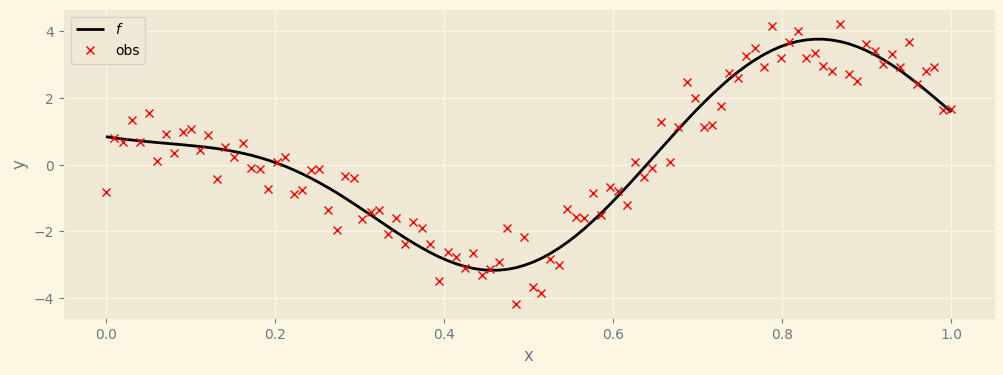

In [4]:
random_random_seed = np.random.randint(0, 10000 + 1)
print('seed:', random_random_seed)
key_data = jrnd.PRNGKey(12345)  # 1106, 5368, 8928, 5609

lengthscale_ = 0.2
output_scale_ = 5.0
obs_noise_ = 0.7
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]  # NOTE: Rossie seem to use x-domain of [-1, 1]

x_mean = jnp.mean(x)
x_std = jnp.std(x)
print(f'x: mean {jnp.round(x_mean, decimals=10)}, std {x_std}')

kernel = jk.RBF()
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x) + 1e-6*jnp.eye(n)
# plot_cov(K, 'true cov')

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key_data, shape=(n,))
f_true = jnp.dot(L, z) + jnp.zeros_like(z)  # NOTE: True GP had mean=1

_, obs_key = jrnd.split(key_data)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(
    f=f_true,
    lengthscale=lengthscale_,
    variance=output_scale_,
    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'$f$')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([0., 1.])
plt.legend()

# WIP implementing

Set up the GP models, either with $\mathbf{f}$ sampled explicitly, or with $\mathbf{f}$ margnalized out (theobvious choice for a Gaussian likelihood, but sampling is shown for pedagogical reasons):

## Prior & init. model

In [5]:
# prior over covariance hyperparameters, likelihood, and inducing inputs.

num_inducing_points = 20

priors = dict(
    kernel=dict(  # Rossi uses lognormal priors over kernel parameters. 
        # NOTE: Rossi uses a seperate lengthscale per feature.
        #   - do they mean locations with features? Or is this about multiple inputs?

        lengthscale = dx.Transformed( 
            dx.Normal(loc=0.0, scale=1.0),
            tfb.Exp()), 
        #lengthscale = dx.Deterministic(loc=lengthscale_),

        variance = dx.Transformed( 
            dx.Normal(loc=0.0, scale=1.0),
            tfb.Exp())),
        #variance = dx.Deterministic(loc=output_scale_)),

    likelihood=dict(  # actually not modeled in Rossi
        obs_noise = dx.Transformed(
            dx.Normal(loc=0.0, scale=1.0), 
            tfb.Exp())),
        #obs_noise = dx.Deterministic(loc=obs_noise_)),
        

    inducing_inputs_Z=dict( 
    # NOTE: Defining distribution over Z directly results in an error
        # the __init__ tries to sample from each distribution in the prior.
        mean=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_mean),
        scale=dx.Deterministic(
            loc=jnp.ones(shape=num_inducing_points) * x_std*.8)))

gp_sparse = SparseGPModel(
    x, y, 
    cov_fn=jk.RBF(), priors=priors, 
    num_inducing_points=num_inducing_points,
    f_true=f_true)  

## Gibbs (for-loop)

### first gibbs_state

In [6]:
%%script false --no-raise-error  # hack to skip execution of a cell

# playground, for testing only
gibbs_state = gp_sparse.init_fn(
    key=key, 
    num_particles = sampling_parameters['num_particles'])

def plot_prior():
    # plot true function, inducing points, estimated function
    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5)
    plt.plot(x, gibbs_state.position['f'], label=r'prior $f$', color='lightblue')
    plt.plot(
        gibbs_state.position['Z'], 
        gibbs_state.position['u'], 
        'x', 
        label='inducing points', 
        color='red',
        alpha=1.)
    plt.xlabel('x & Z')
    plt.ylabel('y & u')
    # plt.xlim([0., 1.])
    plt.legend()
    plt.savefig(f'results/prior.png')
    plt.show()

plot_prior()

# plot covariance matrices
def _plot_covs():
    for t in gibbs_state.position['dev'].keys():
        c = gibbs_state.position['dev'][t]
        print(f'{t}: {c.shape}')
        if t == 'cov_gp':
            plot_cov(c, t, show_negative=False, figsize=(8, 12))
            plot_cov(c, t + '\nred = negative values', 
                    show_negative=True, 
                    figsize=(8, 12))
        else:
            plot_cov(c, t, show_negative=False)

# _plot_covs()

### utils

In [7]:
# utils: pretty print gibbs state, IPython progress bar

def update_progress(progress, extra=''):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, extra)



### training loop

In [8]:
%%time
%%script false --no-raise-error  # hack to skip execution of a cell

gibbs_state_hist = [gibbs_state]
for i in range(1, sampling_parameters['num_mcmc_steps']):
    t_start = time.time()

    key, key_gibbs = jrnd.split(key)  # TODO: Should I reuse the same key every iteration instead of splitting a new one?
    gibbs_state_, _ = gp_sparse.gibbs_fn(key_gibbs, gibbs_state_hist[-1], sampling_parameters)
    gibbs_state_hist.append(gibbs_state_)
    
    # dumb current gibbst state history
    if i % 100 == 0:
        file = open(f'results/gibbs_state_hist.pkl', 'wb')
        pickle.dump(gibbs_state_hist, file)
        file.close()

    # update progressbar
    if i % 10 == 0:
        update_progress(i / sampling_parameters["num_mcmc_steps"])

    # show and save plots
    if (i % 50 == 0) and (i > 0):
        plot_posterior(gibbs_state_hist, num_of_samples=1_000, iter=i)
        plot_inducing_variables(gibbs_state_hist)
        plot_training_history(gibbs_state_hist)
        # plot_cov(gibbs_state_hist[-1].position['dev']['cov_gp'], title='gp', iter=i)

    if i % 10 == 0:
        print(f'    iter {i}, duration: {jnp.round(time.time() - t_start, decimals = 3)} sec')

update_progress(1)
plot_posterior(
    gibbs_state_hist,   
    num_of_samples=1_000, 
    iter=sampling_parameters['num_mcmc_steps'])
plot_inducing_variables(gibbs_state_hist)
plot_training_history(gibbs_state_hist)

CPU times: user 1.26 ms, sys: 2.91 ms, total: 4.16 ms
Wall time: 7.2 ms


## Gibbs (Jax)

In [9]:
%%script false --no-raise-error  # hack to skip execution of a cell
%%time

# randomize the models inital state
random_random_seed = np.random.randint(0, 10000 + 1)
print('random random seed:', random_random_seed)
key = jrnd.PRNGKey(random_random_seed)

# define parameters for inference
sampling_parameters = dict(
    num_burn=0,  # gibbs
    num_samples=20_000  # gibbs | num_mcmc_steps
    )
    
# run inference
with jax.disable_jit(disable=False):  # TODO: Add alarming print when disabled
    key, key_inference = jrnd.split(key)

    initial_state, gibbs_states = gp_sparse.inference(
        key_inference, 
        mode='gibbs', 
        sampling_parameters=sampling_parameters)

 # save all data to file
if False:
    data = {
        'x': x,
        'f_true': f_true,
        'initial_state': initial_state,
        'gibbs_states': gibbs_states
    }
    file = open(f'results/gibbs_states.pkl', 'wb')
    pickle.dump(data, file)
    file.close()

### Analyze results

In [10]:
%%script false --no-raise-error
print('\nGibbs-state keys:')
# print all keys and len/shape of corresponding data
for k in gibbs_states.position.keys():
    try:
        print('    ', k, 
              gibbs_states.position[k]
              if len(gibbs_states.position[k].shape) == 0 
              else gibbs_states.position[k].shape, 
              end='\n')
    except:
        print('    ', k, len(gibbs_states.position[k]), end='\n')
print()

print('\ninital values')
print('lengthscale:', initial_state.position['lengthscale'])
print('variance', initial_state.position['variance'])

In [11]:
%%script false --no-raise-error

def plot_prior(initial_state):
    """
    Plot true function and prior
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)
    
    plt.title(f'true function, noisy data, and prior')
    plt.legend()
    plt.show()

def plot_posterior(gibbs_state_hist, initial_state, num_of_samples=100):
    """
    Plot true function and posterior samples
    
    num_of_states - number of samples starting from the back of the chain to use for plotting the posterior. 

    """

    plt.figure(figsize=(12, 4))
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    plt.plot(
        gibbs_state_hist.position['Z'][-1],
        # jnp.mean(gibbs_state_hist.position['Z'][-num_of_samples: ], axis=0),
        gibbs_state_hist.position['u'][-1], 
        # jnp.mean(gibbs_state_hist.position['u'][-num_of_samples: ], axis=0),
        'x', 
        label='posterior\ninducing points\nlast sample', 
        color='red',
        alpha=1.0,
        zorder=2)

    # plt.plot(
    #     gibbs_state_hist.position['Z'][-num_of_samples: ],
    #     gibbs_state_hist.position['u'][-num_of_samples: ], 
    #     'x', 
    #     # label='posterior\ninducing points\nall samples', 
    #     color='red',
    #     alpha=0.1,
    #     zorder=0)

    plt.plot(
        # gibbs_state_hist.position['Z'][-1],
        jnp.mean(gibbs_state_hist.position['Z'][-num_of_samples: ], axis=0),
        #gibbs_state_hist.position['u'][-1], 
        jnp.mean(gibbs_state_hist.position['u'][-num_of_samples: ], axis=0),
        'x', 
        label='mean posterior\ninducing points', 
        color='orange',
        alpha=1.0,
        zorder=2)

    # prior
    plt.plot(
        x, 
        initial_state.position['f'], 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    plt.plot(
        initial_state.position['Z'], 
        initial_state.position['u'], 
        'x', 
        label='prior\ninducing points', 
        color='cornflowerblue',
        alpha=1,
        lw=1,
        zorder=1)

    # get last `num_of_states` gibbs states
    f_samples = gibbs_state_hist.position['f'][-1*num_of_samples:]

    # plot each sample
    '''for i in range(f_samples.shape[0]):  # negativ indexing to select last elements
        plt.plot(x, f_samples[i], 
                color='orange',
                alpha=0.1)'''
        
    # plot average and confidence intervals
    f_mean = jnp.mean(f_samples, axis=0)
    f_hdi_lower = jnp.percentile(f_samples, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_samples, q=97.5, axis=0)
    ax = plt.gca()
    ax.plot(x, f_mean, label='mean f~GP', color='green', lw=1.5, zorder=1)
    ax.fill_between(
        x.flatten(), f_hdi_lower, f_hdi_upper, 
        alpha=0.5, color='lightgreen', lw=0)
    # ax.set_ylim(
    #     jnp.min(f_true) - 1, 
    #     jnp.max(f_true) + 1)
    
    plt.title(f'last {f_samples.shape[0]} posterior samples')
    plt.legend()
    # plt.savefig(f'results/posterior_iter{iter}.png')
    # plt.savefig(f'results/posterior.png')
    plt.show()
    # plt.close()
    
def plot_cov_param_trajectory(lengthscale=None, variance=None, title=''):
    # Plot training history

    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    cmap = plt.colormaps.get_cmap('Set1')

    if lengthscale is not None:
        ax.plot(
            lengthscale, 
            label='lengthscale', 
            color=cmap(0), alpha=1,
            zorder=1)
        ax.axhline(
            lengthscale_, 
            linestyle='--', 
            label=f'true lengthscale ({lengthscale_})',
            color=cmap(0), alpha=1,
            zorder=2)
        ax.set_ylabel('lengthscale', color=cmap(0))
        lengthscale_mean = jnp.mean(lengthscale)
        lengthscale_hdi_lower = jnp.percentile(lengthscale, q=2.5, axis=0)
        lengthscale_hdi_upper = jnp.percentile(lengthscale, q=97.5, axis=0)
        # ax.set_ylim(lengthscale_hdi_lower*1.5, lengthscale_hdi_upper*1.5)
        # if lengthscale.shape[0] >= 200:
        #     ax.set_ylim(
        #         jnp.min(lengthscale[400:])*1.5, 
        #         jnp.max(lengthscale[400:])*1.5)

    if variance is not None:
        ax2.plot(
            variance, 
            label='variance', 
            color=cmap(1), alpha=1,
            zorder=3)
        ax2.axhline(output_scale_, 
                    linestyle='--', 
                    label=f'true variance ({output_scale_})',
                    color=cmap(1), alpha=1,
                    zorder=4)
        ax2.set_ylabel('variance', color=cmap(1))

    # create shared legend for both axis
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax.set_xlabel('Gibbs iterations')
    plt.title(title)
    plt.show()
    # plt.close()

def plot_param_trajectory(
        param_gibbs_hist:dict, 
        title:str='', 
        color_idxs:list=[0, 1]):
    # Plot training history

    fig, ax = plt.subplots(figsize=(12, 4))    
    cmap = plt.colormaps.get_cmap('Set1')

    for i, (param, data) in enumerate(param_gibbs_hist.items()):

        if i == 1:
            ax = ax.twinx()
        ax.plot(data, label=param, color=cmap(color_idxs[i]))
        # ax.axhline(lengthscale_, linestyle='--', color=cmap(0), 
        #         label=f'true lengthscale ({lengthscale_})')
        ax.set_ylabel(param, color=cmap(color_idxs[i]))
        ax.legend()

    # create shared legend for both axis
    # lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax.set_xlabel('iterations')
    plt.title(title)
    plt.show()
    # plt.close()

def plot_u_trajectories(gibbs_state_hist, gibbs_key:str='u'):
    # plot u trajectories
    u_samples = gibbs_state_hist.position[gibbs_key]

    iter_idx = range(len(u_samples))
    color = plt.cm.hsv(np.linspace(0, 1, u_samples.shape[1]))

    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    ax.set_facecolor('grey')
    for i in range(u_samples.shape[1]):
        plt.plot(iter_idx, u_samples[:, i], alpha=0.7, color=color[i], lw=1)
    plt.xlabel('Gibbs iterations')
    plt.title(f'{gibbs_key} samples')
    # plt.savefig(f'results/train_hist_{gibbs_key}.png')
    plt.show()
    # plt.close()

def plot_inducing_variables(gibbs_state_hist):
    plot_u_trajectories(gibbs_state_hist, gibbs_key='u')
    plot_u_trajectories(gibbs_state_hist, gibbs_key='Z')

def plot_param_histogram(
    param_samples:dict,
    bins:int = 20,
    title:str='', 
    color_idxs:list=[0, 1]):

    fig, ax = plt.subplots(
        ncols=len(param_samples), 
        figsize=(12, 4), 
        squeeze=False)
    cmap = plt.colormaps.get_cmap('Set1')

    for i, (param, data) in enumerate(param_samples.items()):
        ax[0, i].hist(
            data,
            density=True,
            bins=bins, 
            color=cmap(color_idxs[i]),)
        ax[0, i].set_title(param)

    plt.suptitle(title)
    plt.show()


plot_prior(initial_state)
plot_posterior(
    gibbs_states,
    initial_state,
    num_of_samples=sampling_parameters['num_samples'])
plot_param_histogram(
    param_samples = {
        'lengthscale': gibbs_states.position['lengthscale'],
        'variance': gibbs_states.position['variance'],
        'obs_noise': gibbs_states.position['obs_noise']
        },
    color_idxs=[0, 1, 2]
)
plot_inducing_variables(gibbs_states)
plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'],
    variance = gibbs_states.position['variance'])
plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'])
plot_cov_param_trajectory(
    variance = gibbs_states.position['variance'])

plot_cov_param_trajectory(
    lengthscale = gibbs_states.position['lengthscale'][:100],
    variance = gibbs_states.position['variance'][:100],
    title='first 100 iterations')
plot_param_trajectory(
    param_gibbs_hist = {
        'lengthscale': gibbs_states.position['lengthscale'][200:],
        'variance': gibbs_states.position['variance'][200:],
        },
    title='after 200 iter',
    color_idxs=[0, 1]
    )
plot_param_trajectory(
    param_gibbs_hist = {'obs_noise': gibbs_states.position['obs_noise']},
    color_idxs=[2]
    )

## SMC-in-Gibbs

In [12]:
%%time
# TODO: Move everything but infernece call to different cell for accurate run-time measurement

# randomize the models inital state
random_random_seed = np.random.randint(0, 10000 + 1)
# random_random_seed = 8180
print('random random seed:', random_random_seed)
key = jrnd.PRNGKey(random_random_seed)

# define parameters for inference
sampling_parameters = dict(
    num_particles = 100,  # SMC
    num_mcmc_steps = 10   # SMC
    )
    
# run inference
with jax.disable_jit(disable=False), jax.debug_nans():
    # TODO: Add alarming print when disabled=True
    # BUG: JAX does not detect nan's when jit disable=False
    key, key_inference = jrnd.split(key)

    initial_particles, particles, _, marginal_likelihood = gp_sparse.inference(
        key_inference, 
        mode='gibbs-in-smc', 
        sampling_parameters=sampling_parameters)

    # unpack results for easy access
    particles = particles.particles

random random seed: 2620
CPU times: user 8min 14s, sys: 5min 3s, total: 13min 18s
Wall time: 2min


In [13]:
%%script false --no-raise-error

def f(x):
  return jnp.log(x) * jnp.nan

r = 0
with jax.disable_jit(disable=False), jax.debug_nans():
    r = jax.jit(f)(1e-400)

print(r)

'''
Here debug_nans is triggered if code is jitted. 
meaning the GP code produces NaN's when not jitted?
'''


In [14]:
print('prior samples means\n')
for k in initial_particles.position.keys():
    curr_part = initial_particles.position[k]
    
    print(k, end=':\n')
    if type(curr_part) == dict:
        for sk in curr_part.keys():
            curr_hyp = curr_part[sk]
            print(
                '    ', 
                sk, curr_hyp.shape, 
                jnp.round(jnp.mean(curr_hyp), decimals=3), 
                jnp.round(jnp.var(curr_hyp), decimals=3))
    else:
        print(
            '  ',
            curr_part.shape)

prior_lengthscale_mean = jnp.mean(initial_particles.position['kernel']['lengthscale'])
prior_variance_mean = jnp.mean(initial_particles.position['kernel']['variance'])
prior_obs_noise_mean = jnp.mean(initial_particles.position['likelihood']['obs_noise'])

prior samples means

inducing_inputs_Z:
     mean (100, 20) 0.5 0.0
     scale (100, 20) 0.233 0.0
kernel:
     lengthscale (100,) 1.309 2.2800000000000002
     variance (100,) 1.966 5.748
likelihood:
     obs_noise (100,) 1.5070000000000001 2.57
Z:
   (100, 20)
u:
   (100, 20)
f:
   (100, 100)


## Full latent GP

In [15]:
%%time
# lgp_inital = initial_particles
# lgp_particles = particles
# lgp_marginal_likelihood = marginal_likelihood
# %%script false --no-raise-error
# TODO: Move everything but infernece call to different cell for accurate run-time measurement

# get subset of priors used for sparse GP
priors_lgp = {}
priors_lgp['kernel'] = priors['kernel']
priors_lgp['likelihood'] = priors['likelihood']

gp_latent = FullLatentGPModel(x, y, cov_fn=jk.RBF(), priors=priors_lgp)

key, gpl_key = jrnd.split(jrnd.PRNGKey(random_random_seed))
lgp_inital, lgp_particles, _, lgp_marginal_likelihood = gp_latent.inference(
    gpl_key,
    mode='gibbs-in-smc',
    sampling_parameters=sampling_parameters)

lgp_particles = lgp_particles.particles

(100,)
CPU times: user 3min 58s, sys: 47.2 s, total: 4min 45s
Wall time: 33.5 s


## Analyzing results

### Plot Posterior(s)

In [16]:
print(marginal_likelihood, jnp.exp(marginal_likelihood))  # BUG: marginal likelihood of sparse GP is nan
print(lgp_marginal_likelihood, jnp.exp(lgp_marginal_likelihood))

-145.7608935623315 4.9756319580518586e-64
-152.31567868941133 7.081760543923473e-67


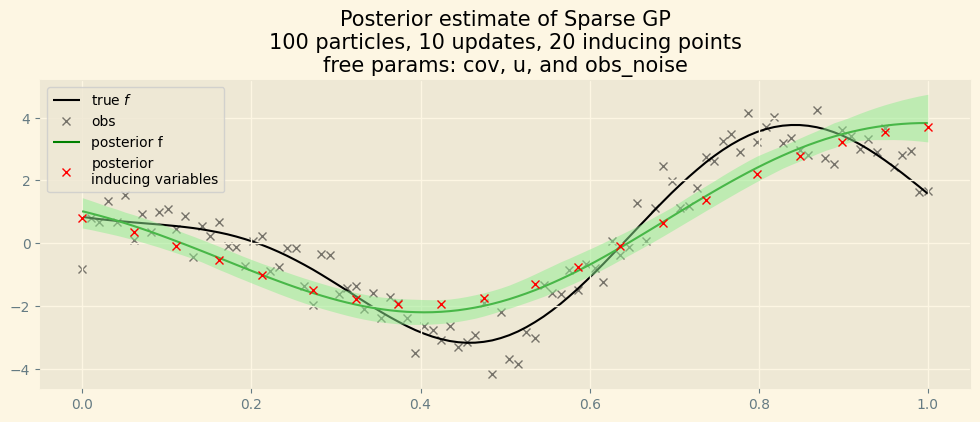

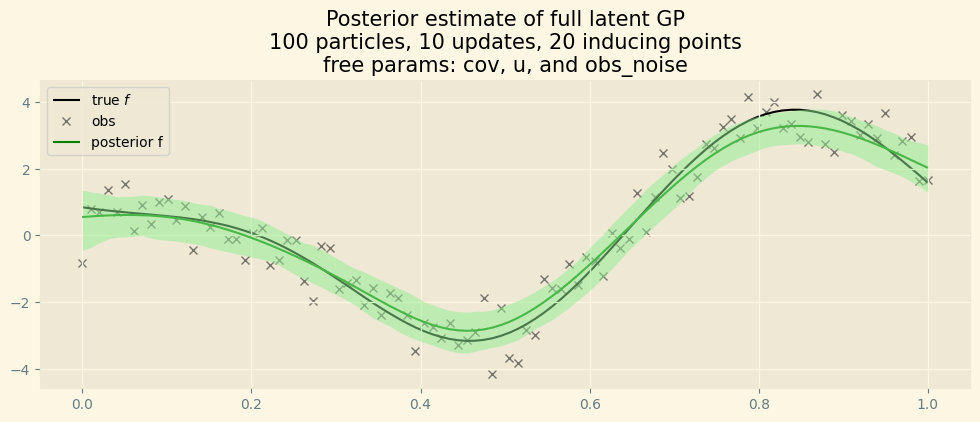

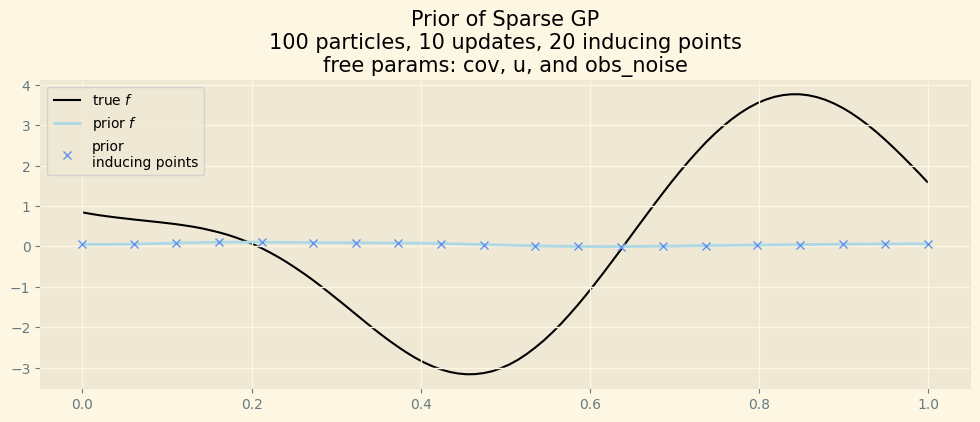

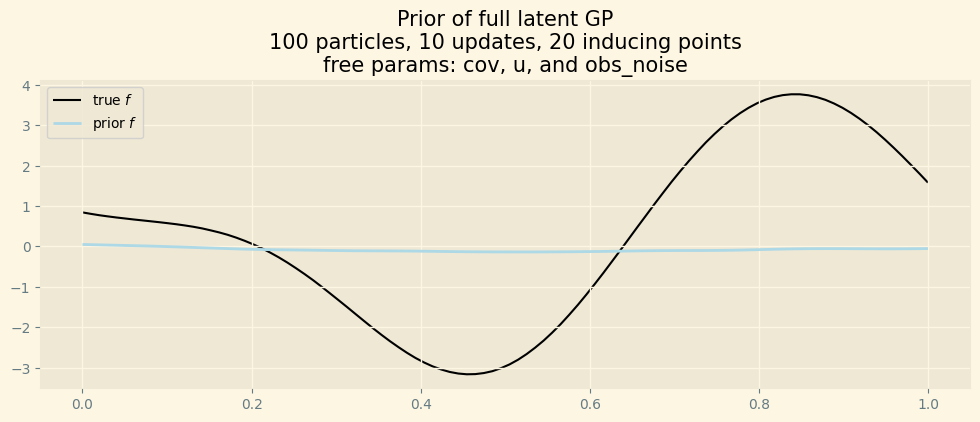

In [17]:
def particle_avg_hdi(particles):
    # plot average and confidence intervals
    mean = jnp.mean(particles, axis=0)
    hdi_lower = jnp.percentile(particles, q=2.5, axis=0)
    hdi_upper = jnp.percentile(particles, q=97.5, axis=0)
    return mean, hdi_lower, hdi_upper


def plot_smc_prior(initial_particles, title='', figsize=(12, 4)):
    plt.figure(figsize=figsize)

    # observations and true function
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)

    # detect Nans and print locations
    nans = np.argwhere(np.isnan(initial_particles.position['f']))
    for p in np.unique(nans[:, 0]):
        nan_loc = nans[np.argwhere(nans[:, 0] == p)][:, 0, 1]
        ic(f'{len(nan_loc)} NaNs in f in particle {p}')

     # prior f
    f_prior_mean, _, _  = particle_avg_hdi(
        initial_particles.position['f'])
    plt.plot(
        x, 
        f_prior_mean, 
        label=r'prior $f$', 
        color='lightblue',
        alpha=1,
        lw=2,
        zorder=1)
    
    # prior inducing points
    if 'Z' in initial_particles.position.keys():
        (Z_prior_mean, 
        Z_prior_hdi_lower, 
        Z_prior_hdi_upper) = particle_avg_hdi(initial_particles.position['Z'])
        (u_prior_mean, 
        u_prior_hdi_lower, 
        u_prior_hdi_upper) = particle_avg_hdi(initial_particles.position['u'])
        plt.plot(
            Z_prior_mean, 
            u_prior_mean, 
            'x', 
            label='prior\ninducing points', 
            color='cornflowerblue',
            alpha=1,
            lw=1,
            zorder=1)
        
    plt.legend()
    plt.title(title, fontsize=15)
    plt.show()

def plot_smc_posterior(particles, title='', figsize=(12, 4)):
    plt.figure(figsize=figsize)

    # observations and true function
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    # f | particle average
    fp_mean, fp_hdi_lower, fp_hdi_upper = particle_avg_hdi(particles['f'])
    ax = plt.gca()
    ax.plot(x, fp_mean, label='posterior f', color='green', lw=1.5, zorder=1)
    ax.fill_between(
        x.flatten(), fp_hdi_lower, fp_hdi_upper, 
        alpha=0.5, color='lightgreen', lw=0)
    
    # Plot inducing points
    if 'u' in particles.keys():
        up_mean, up_hdi_lower, up_hdi_upper = particle_avg_hdi(particles['u'])
        zp_mean, zp_hdi_lower, zp_hdi_upper = particle_avg_hdi(particles['Z'])
        plt.plot(
            zp_mean, up_mean,
            'x', 
            label='posterior\ninducing variables', 
            color='red',
            alpha=1.0,
            zorder=2)
    
    plt.legend()
    plt.title(title, fontsize=15)
    plt.show()

def plot_smc_posterior_particels(particles, idxs=None, sub_title=''):
    plt.figure(figsize=(12, 4))

    # observations and true function
    plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
    plt.plot(x, y, 'x', label='obs', color='black', alpha=0.5, zorder=-1)

    # f particles
    if idxs == None:
        idxs = range(particles['f'].shape[0])
    for i in idxs:
        plt.plot(
            x, particles['f'][i], 
            label='posterior f' if i==0 else '', 
            color='green', lw=1.5, zorder=1, alpha=0.6)
    
        # Plot inducing points
        # up_mean, up_hdi_lower, up_hdi_upper = particle_avg_hdi(particles['u'])
        # zp_mean, zp_hdi_lower, zp_hdi_upper = particle_avg_hdi(particles['Z'])
        plt.plot(
            particles['Z'][i], particles['u'][i],
            'x', 
            label='posterior\ninducing variables', 
            color='red',
            alpha=1.0,
            zorder=2)
    
    plt.legend()
    if sub_title != '':
        sub_title = f'\n{sub_title}'
    plt.title(f'Posterior estimate of Sparse GP{sub_title}')
    plt.show()


num_particles = sampling_parameters['num_particles']
num_upates = sampling_parameters['num_mcmc_steps']
sub_title = f'\n{num_particles} particles, {num_upates} updates, {num_inducing_points} inducing points'
sub_title = sub_title + '\nfree params: cov, u, and obs_noise' 


plot_smc_posterior(
    particles, 
    title=f'Posterior estimate of Sparse GP' + sub_title)
plot_smc_posterior(
    lgp_particles, 
    title=f'Posterior estimate of full latent GP' + sub_title.split('\nset')[0])

# BUG: prior plot of sparseGP is empty.
#   The functions values probably contain a nan which causes the mean to return nan
plot_smc_prior( 
    initial_particles, 
    title=f'Prior of Sparse GP' + sub_title)
plot_smc_prior(
    lgp_inital, 
    title=f'Prior of full latent GP' + sub_title.split('\nset')[0])


# for i in range(10, 20):
#     plot_smc_posterior_particels(
#         particles,
#         idxs=[i],
#         sub_title=sub_title)


### Plot parameters 

POSTERIOR


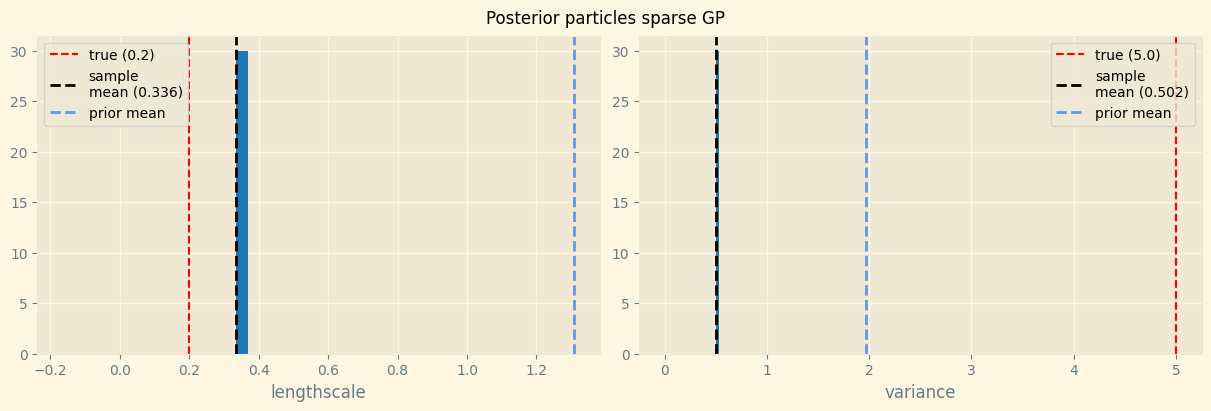

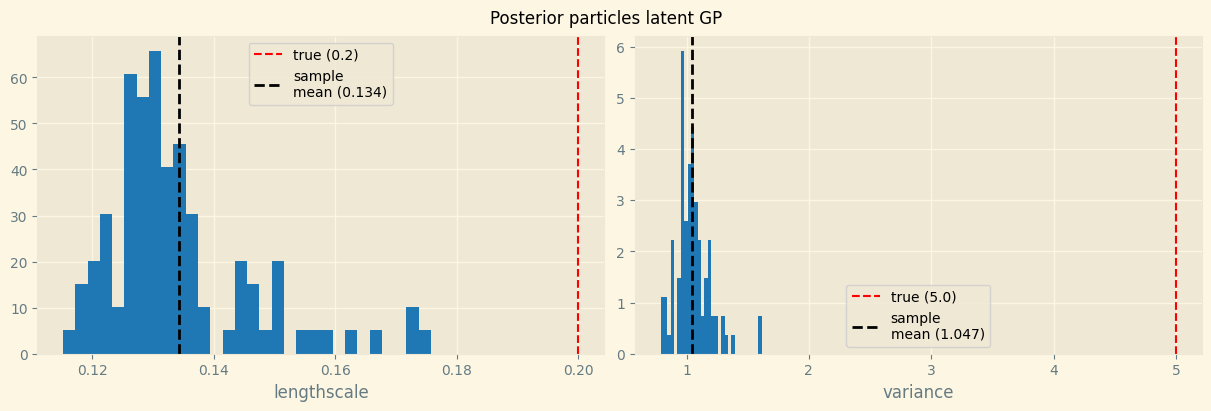

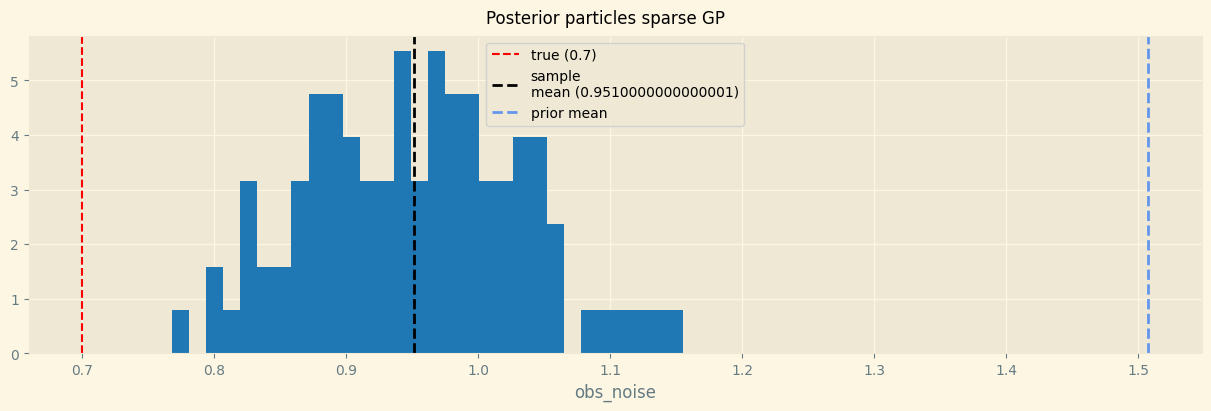

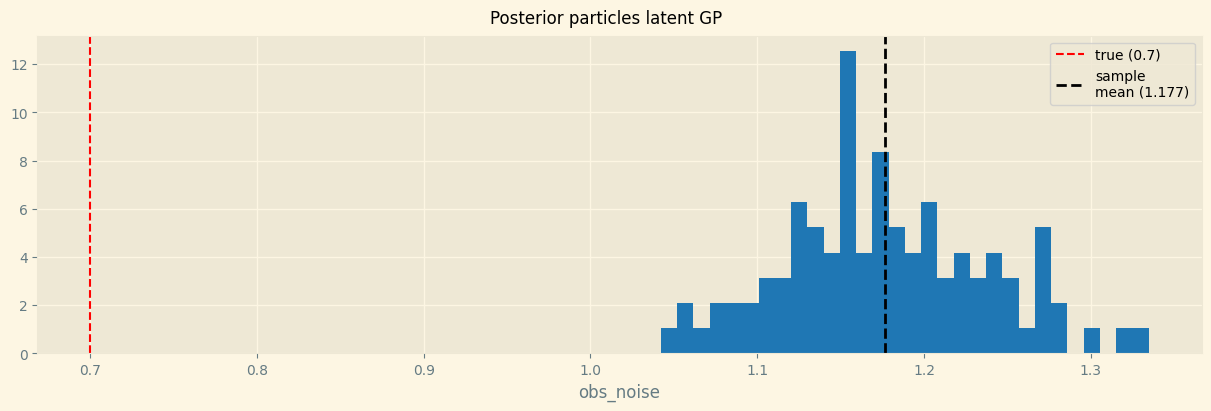

PRIORS


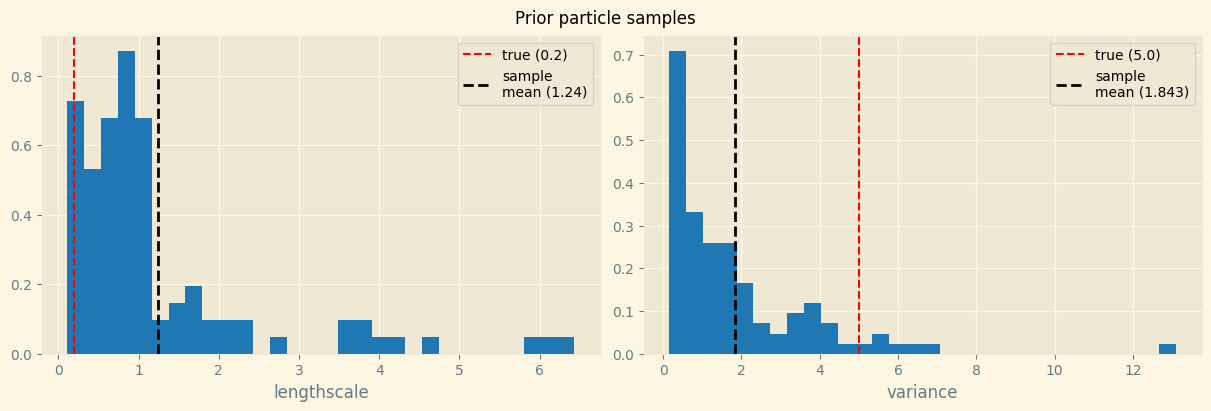

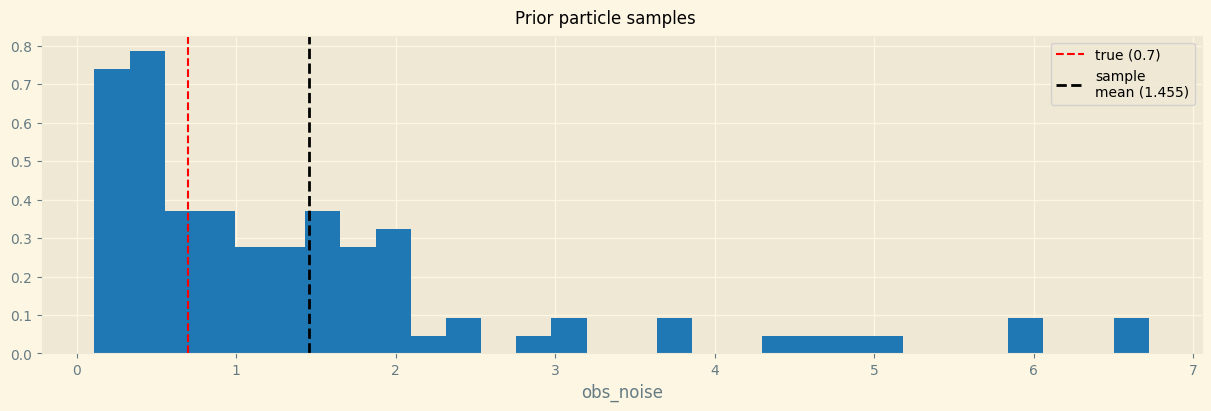

In [18]:
def plot_parameter_histograms(particles, title='', prior_values=None):

    params = list(particles.keys())

    _, axs = plt.subplots(
        nrows=1, ncols=len(params), 
        constrained_layout=True,
        sharex='col', sharey='col', figsize=(12, 4))

    for i, p in enumerate(params):
        
        ax = axs if type(axs) == plt.Axes else axs[i]

        pd = particles[p]
        # There are some outliers that skew the axis
        pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
        pd_filtered = jnp.extract(pd>pd_l, pd)
        pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
        if pd_filtered.shape[0] == 0:
            pd_filtered = pd

        ax.hist(pd_filtered, bins=30, density=True, color='tab:blue')
        ax.set_xlabel(p)
        
        if p in ground_truth.keys():
            ax.axvline(
                x=ground_truth[p], 
                ls='--', lw=1.5, c='red', 
                label=f'true ({ground_truth[p]})')
        
        mean = jnp.mean(pd_filtered)
        ax.axvline(
            x=mean, 
            ls='--', c='black', 
            label=f'sample\nmean ({jnp.round(mean, decimals=3)})')
        
        if prior_values:
            ax.axvline(
            x=prior_values[i], 
            ls='--', c='cornflowerblue',
            
            label=f'prior mean')
                
        ax.legend()

    plt.suptitle(title)
    plt.show()

print('POSTERIOR')
plot_parameter_histograms(
   particles=particles.get('kernel', {}),
   title='Posterior particles sparse GP',
   prior_values=[prior_lengthscale_mean, prior_variance_mean])
plot_parameter_histograms(
   particles=lgp_particles.get('kernel', {}),
   title='Posterior particles latent GP')

plot_parameter_histograms(
   particles=particles.get('likelihood', {}),
   title='Posterior particles sparse GP',
   prior_values=[prior_obs_noise_mean])
plot_parameter_histograms(
   particles=lgp_particles.get('likelihood', {}),
   title='Posterior particles latent GP')


print('PRIORS')
plot_parameter_histograms(
    particles=initial_particles.position.get('kernel', {}), 
    title='Prior particle samples')
plot_parameter_histograms(
    particles=initial_particles.position.get('likelihood', {}), 
    title='Prior particle samples')

### Plot predictive f and u

In [19]:
# test new predictive function
_, key_pred = jrnd.split(key)
    
f_pred = gp_sparse.predict_f_from_u(key_pred, jnp.linspace(-1.25, 1.25, num=150))

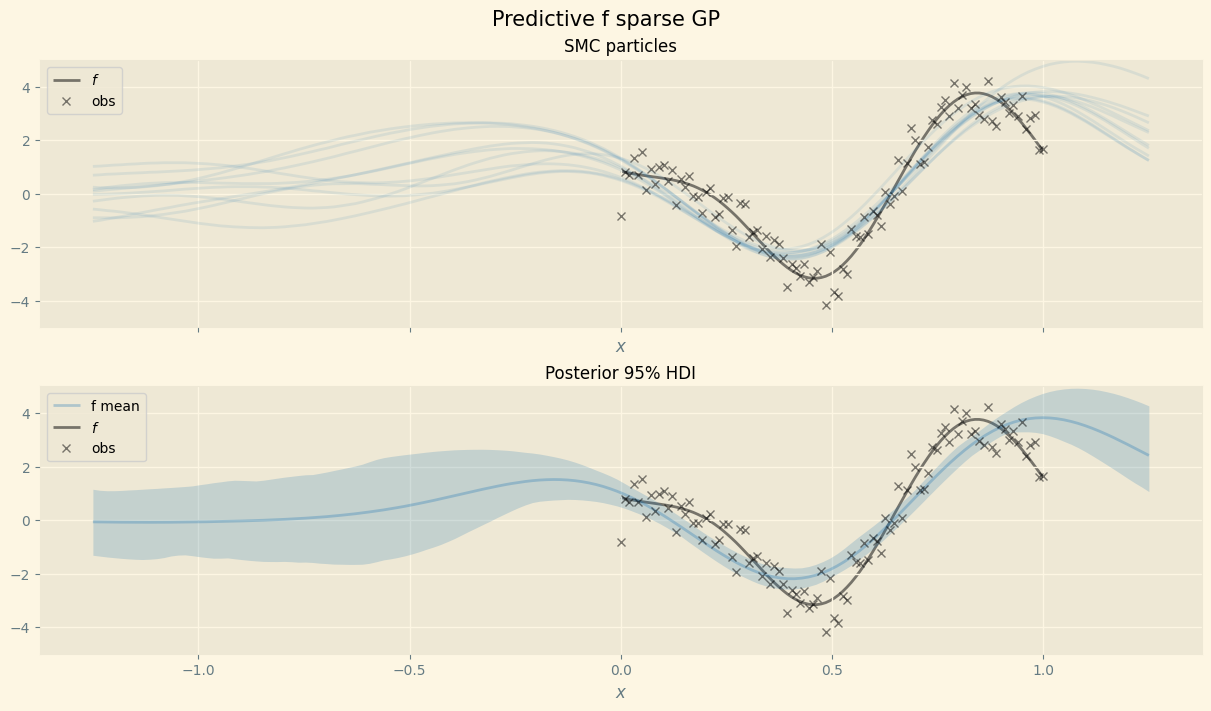

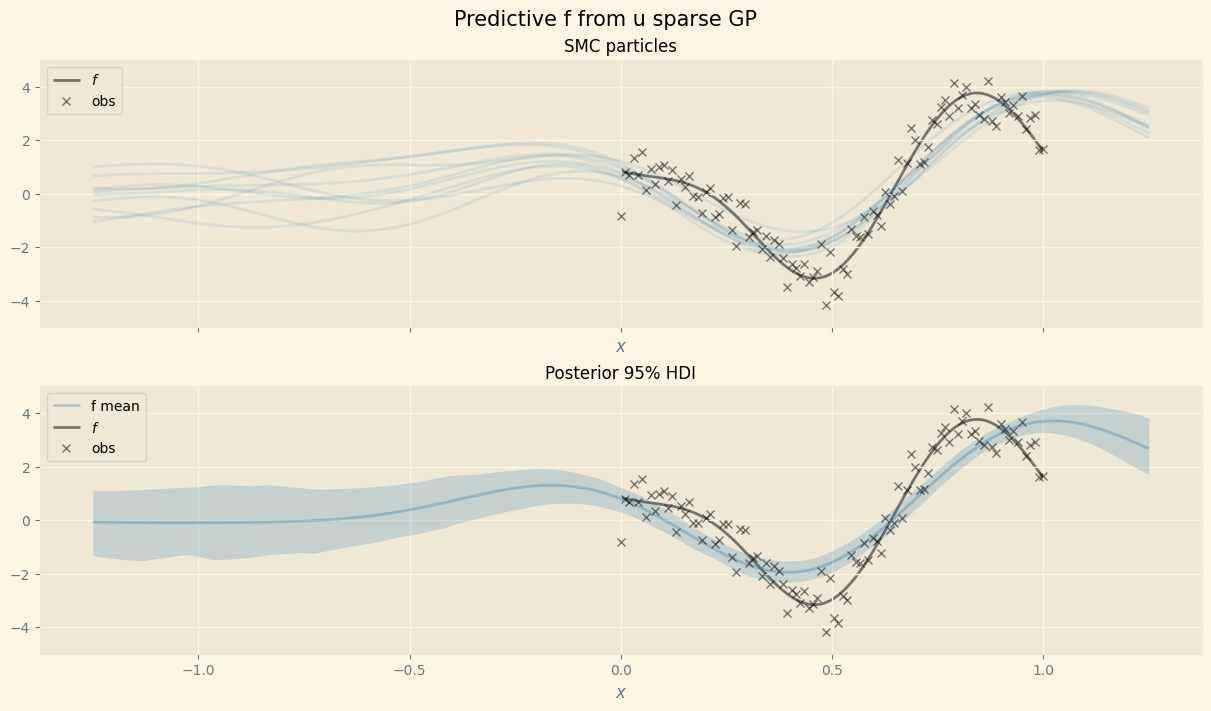

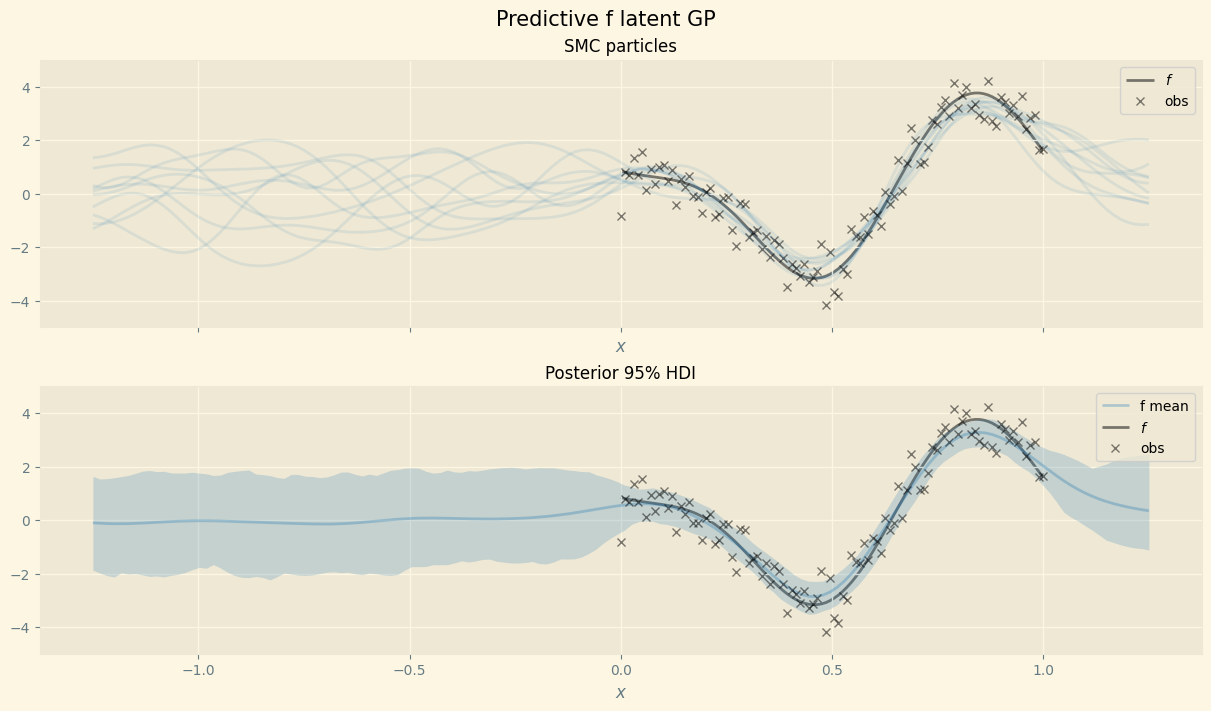

In [20]:
def plot_predictive_f(key, predictive_fn, x_pred, title):
    _, key_pred = jrnd.split(key)
    
    f_pred = predictive_fn(key_pred, x_pred)

    # setup plotting
    fig, axes = plt.subplots(
        nrows=2, ncols=1, figsize=(12, 7), sharex=True,
        sharey=True, constrained_layout=True)

    # plot each particle
    ax = axes[0]
    for i in jnp.arange(0, num_particles, step=10):
        ax.plot(
            x_pred, f_pred[i, :], 
            alpha=0.1, color='tab:blue', zorder=2)

    # mean and HDI over particles
    ax = axes[1]
    f_mean = jnp.mean(f_pred, axis=0)
    f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
    f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)
    ax.plot(
        x_pred, f_mean, 
        color='tab:blue', lw=2, zorder=2, alpha=0.3,
        label='f mean')
    ax.fill_between(
        x_pred, f_hdi_lower, f_hdi_upper,
        alpha=0.2, color='tab:blue', lw=0)

    # True f, observations and others for all axis
    for ax in axes.flatten():
        ax.plot(x, f_true, 'k', label=r'$f$', zorder=-1, alpha=0.5)
        ax.plot(x, y, 'x', label='obs', color='black', alpha=0.5)
        # ax.set_xlim([-10, 10])
        ax.set_ylim([-5., 5.])
        ax.set_xlabel(r'$x$')
        ax.legend()

    axes[0].set_title('SMC particles', fontsize=12)
    axes[1].set_title('Posterior 95% HDI', fontsize=12)
    fig.suptitle(title, fontsize=15)
    #axes[0].set_ylabel('Latent GP', rotation=0, ha='right');

plot_predictive_f(
    key,
    predictive_fn=gp_sparse.predict_f,
    x_pred=jnp.linspace(-1.25, 1.25, num=150),
    title='Predictive f sparse GP'
)

plot_predictive_f(
    key,
    predictive_fn=gp_sparse.predict_f_from_u,
    x_pred=jnp.linspace(-1.25, 1.25, num=150),
    title='Predictive f from u sparse GP'
)

plot_predictive_f(
    key,
    gp_latent.predict_f,
    x_pred=jnp.linspace(-1.25, 1.25, num=150),
    title='Predictive f latent GP'
)

## Diagnostics

### diagnostics _compute_sparse_gp()

With the code one can test if the compute sparse gp works correctly.

Varying the number of evenly spaced inducing points shows how many points are possible to approximate the true function well. About 16 is works really well in the current setting.

In [21]:
gp_diagnostic = SparseGPModel(
    x, y, 
    cov_fn=jk.RBF(), priors=priors, 
    num_inducing_points=10,
    f_true=f_true)  

dict_keys(['inducing_inputs_Z', 'kernel', 'likelihood', 'Z', 'u', 'f'])


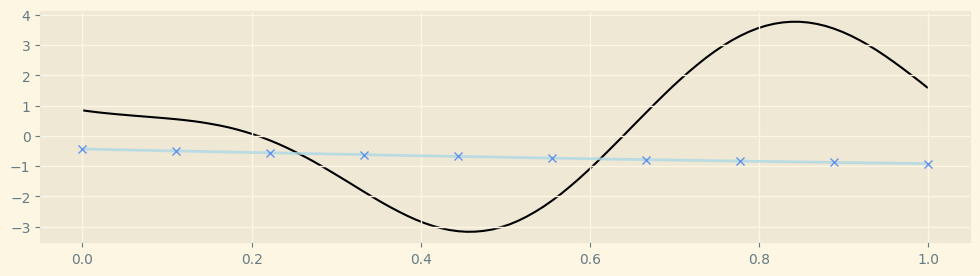

In [22]:
# Calling compute_sparse_gp through init_fn
# NOTE: The endresult is dependent on the prior.

random_random_seed = np.random.randint(0, 10000 + 1)
key = jrnd.PRNGKey(random_random_seed)
key, key_prior = jrnd.split(key)

state = gp_diagnostic.init_fn(key_prior, 1)
print(state.position.keys())

plt.figure(figsize=(12, 3))
plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
plt.plot(
    x, state.position['f'],
    label=r'prior $f$', 
    color='lightblue',
    alpha=0.8, lw=2, zorder=1)
plt.plot(
    state.position['Z'], state.position['u'], 
    'x', 
    label='prior\ninducing points', 
    color='cornflowerblue', 
    alpha=1, lw=1, zorder=1)

ic| 707098194.py:6 in <module>
    cov_params: {'lengthscale': Array(0.2, dtype=float64, weak_type=True),
                 'variance': Array(5., dtype=float64, weak_type=True)}


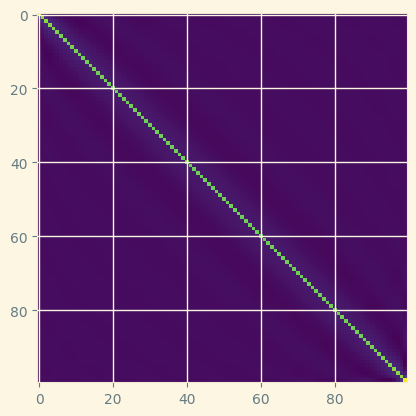

9454


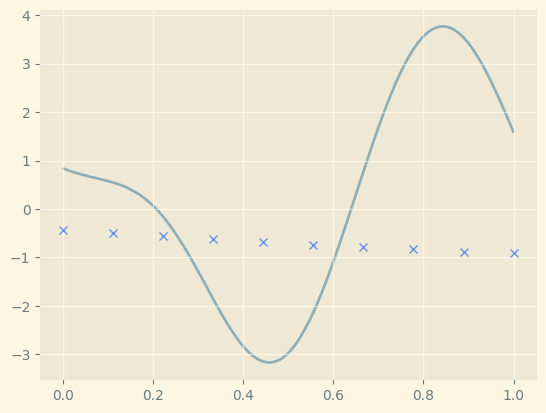

In [23]:
# Calling compute_sparse_gp directly 

cov_params = {
    'lengthscale': jnp.array(lengthscale_),
    'variance': jnp.array(output_scale_)}
ic(cov_params)

mean_gp, cov_gp = gp_diagnostic._compute_sparse_gp(
    cov_params=cov_params, 
    x=x,
    samples_Z=x, 
    samples_u=f_true, 
    add_jitter=True)
plt.imshow(cov_gp)
plt.show()

# Sample from GP
random_random_seed = np.random.randint(0, 10000 + 1)
key = jrnd.PRNGKey(random_random_seed)
print(random_random_seed)
# key, key_sampling = jrnd.split(key)

L = jnp.linalg.cholesky(cov_gp)
z = jrnd.normal(key, shape=[n])
samples_f = jnp.dot(L, z) + mean_gp

plt.plot(x, f_true, 'k', label=r'true $f$', lw=1.5, alpha=1, zorder=-1)
plt.plot(
    x, 
    samples_f, #f_prior_mean, 
    label=r'prior $f$', 
    color='lightblue',
    alpha=0.8,
    lw=2,
    zorder=1)
plt.plot(
    state.position['Z'], state.position['u'], 
    'x', 
    label='prior\ninducing points', 
    color='cornflowerblue', 
    alpha=1, lw=1, zorder=1)